# References
* https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb
* https://www.kaggle.com/code/kamyarazar/stock-price-prediction-lstm-hyperparameter-tuning#Fearure-Scaling

## Imports

In [ ]:
import numpy as np
# I am making some changes
import matplotlib.pyplot as plt
import keras
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, TimeDistributed, Dropout, Bidirectional
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import EarlyStopping
import itertools

## Data

In [82]:
# Original data
data = np.array([58359,59882,76678,51411,34267,50053,50946,42378,35679,42265,
                 47225,56490,59696,62503,56710,48551,61048,52098,51355,49368,
                 41689,37206,36490,43835,45742]).astype('float32')[::-1]

In [128]:
def prepare_data(data, n_past, n_future, tt_split, val_split):

  x_data, y_data = [], []
  data_days = []


  sc = MinMaxScaler(feature_range = (0,1))
  data_scaled = sc.fit_transform(data.reshape(-1,1))

  for i in range(n_past, len(data) - n_future + 1):
    x_data.append(data_scaled[i - n_past:i])
    y_data.append(data_scaled[i])
    data_days.append(list(range(i-n_past, i)))



  x_data = np.array(x_data)
  x_data = x_data.reshape(x_data.shape[0], x_data.shape[1], 1)
  y_data = np.array(y_data).reshape(-1,1)


  split_train_test = int(round(tt_split*len(x_data)))
  split_train_val = int(round(split_train_test*(1-val_split)))

  x_train = x_data[:split_train_test]
  y_train = y_data[:split_train_test]
  data_days_train = data_days[:split_train_test]

  x_test = x_data[split_train_test:]
  y_test = y_data[split_train_test:]
  data_days_test = data_days[split_train_test:]

  x_val = x_data[split_train_val:split_train_test]
  y_val = y_data[split_train_val:split_train_test]
  data_days_val = data_days[split_train_val:split_train_test]


  return x_train, y_train, x_test, y_test, x_val, y_val, sc, data_days_train, data_days_test, data_days_val

x_train, y_train, x_test, y_test, x_val, y_val, sc, data_days_train, data_days_test, data_days_val = prepare_data(data, n_past = 10, n_future = 1, tt_split = 0.8, val_split = 0)

In [129]:
data_days_train, data_days_test

([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  [7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
  [9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]],
 [[12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
  [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]])

## Model

### First model

In [ ]:
regressor = Sequential()

regressor.add(Bidirectional(LSTM(units = 64, return_sequences = True), input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

# Additional LSTM layers
regressor.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 16, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 8, return_sequences = False))

# Dense layers
regressor.add(Dense(units = 16, activation='relu'))
regressor.add(Dense(units = 8, activation='relu'))

# Output layer
regressor.add(Dense(units = 1, activation='linear'))

# Compile model
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

regressor.summary()

In [ ]:
#es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history = regressor.fit(x_train, y_train, validation_split = 0.3, epochs = 100, batch_size = 64)
# callbacks = [es])

### First model's results

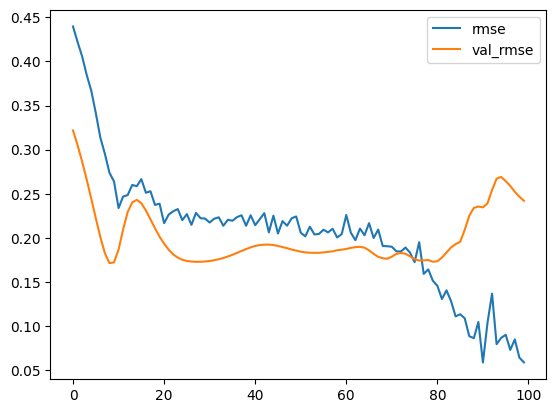

In [145]:
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = 'rmse')
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")
plt.legend()

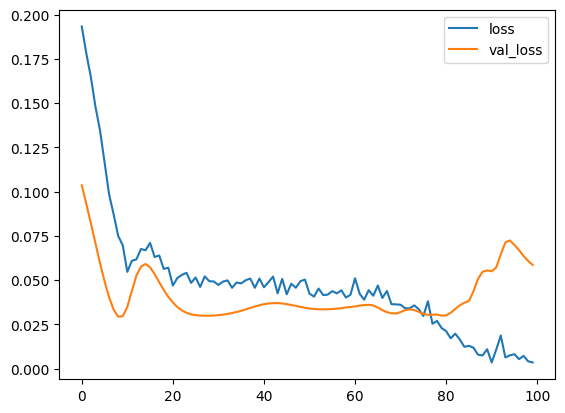

In [148]:
plt.plot(history.epoch, history.history['loss'], label = 'loss')
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss")
plt.legend()

In [147]:
results = regressor.evaluate(x_test, y_test)
print(f"Test loss, test accuracy:", np.round(results, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2471 - root_mean_squared_error: 0.4971
Test loss, test accuracy: [0.2471 0.4971]


In [ ]:
predictions = []
current_input = x_test[-1]

num_future = 20

for _ in range(num_future):
  next_prediction = regressor.predict(current_input.reshape(1,-1))
  predictions.append(next_prediction)

  current_input = np.append(current_input[1:], next_prediction)

predictions = np.squeeze(np.array(predictions))

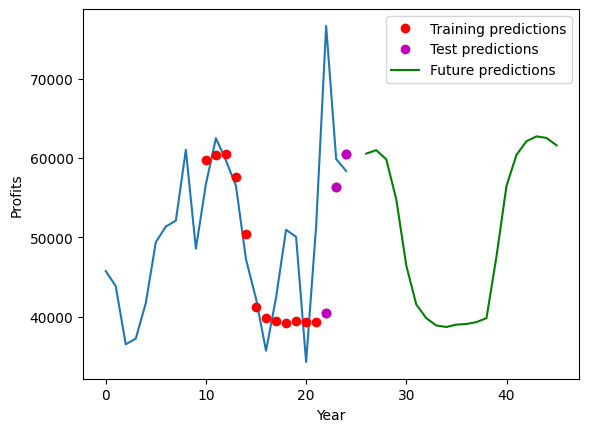

In [173]:
y_pred_train = regressor(x_train)
y_pred_train_normal = sc.inverse_transform(y_pred_train)
plt.plot(data)
plt.plot(range(x_train.shape[1], x_train.shape[1] + len(y_pred_train)),y_pred_train_normal, 'ro', label = 'Training predictions')

y_pred_test = regressor(x_test)
y_pred_test_normal = sc.inverse_transform(y_pred_test)
for i in range(len(y_pred_test_normal)):
  plt.plot(25 - len(x_test) + i, y_pred_test_normal[i], 'mo')

plt.plot(range(25 - len(x_test), 25 - len(x_test) + len(y_pred_test) ),y_pred_test_normal, 'mo', label = 'Test predictions')

plt.plot(range(26,26 + num_future), sc.inverse_transform(predictions.reshape(-1,1)), 'g', label = 'Future predictions')
plt.xlabel('Year')
plt.ylabel('Profits [€]')
plt.legend()


In [161]:
data_days_test

[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]

In [152]:
y_pred_normal

array([[59752.7656651 ],
       [60378.53283977],
       [60502.20745753],
       [57599.02897325],
       [50386.31055309],
       [41205.88116189],
       [39749.17988894],
       [39419.38280416],
       [39232.18698506],
       [39438.76605267],
       [39281.92674789],
       [39308.54893287]])

In [136]:
data_days_test[-1]

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [137]:
x_test

array([[[0.59958506],
        [0.52399147],
        [0.3055339 ],
        [0.18858314],
        [0.03329325],
        [0.19124758],
        [0.3932706 ],
        [0.3722148 ],
        [0.        ],
        [0.40423477]],

       [[0.52399147],
        [0.3055339 ],
        [0.18858314],
        [0.03329325],
        [0.19124758],
        [0.3932706 ],
        [0.3722148 ],
        [0.        ],
        [0.40423477],
        [1.        ]],

       [[0.3055339 ],
        [0.18858314],
        [0.03329325],
        [0.19124758],
        [0.3932706 ],
        [0.3722148 ],
        [0.        ],
        [0.40423477],
        [1.        ],
        [0.60397065]]], dtype=float32)

In [109]:
x_test.shape

(1, 20, 1)

## Hyperparameter tuning

In [9]:
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)


# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''


        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [14]:
config = [[False], [False], [False], [16, 32], [8,16,32], [0.2]]


hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.10874, saving model to best_model.h5



Epoch 2: val_loss improved from 0.10874 to 0.10217, saving model to best_model.h5



Epoch 3: val_loss improved from 0.10217 to 0.09590, saving model to best_model.h5



Epoch 4: val_loss improved from 0.09590 to 0.08986, saving model to best_model.h5



Epoch 5: val_loss improved from 0.08986 to 0.08406, saving model to best_model.h5



Epoch 6: val_loss improved from 0.08406 to 0.07841, saving model to best_model.h5



Epoch 7: val_loss improved from 0.07841 to 0.07297, saving model to best_model.h5



Epoch 8: val_loss improved from 0.07297 to 0.06775, saving model to best_model.h5



Epoch 9: val_loss improved from 0.06775 to 0.06273, saving model to best_model.h5



Epoch 10: val_loss improved from 0.06273 to 0.05793, saving model to best_model.h5



Epoch 11: val_loss improved from 0.05793 to 0.05334, saving model to best_model.h5



Epoch 12: val_loss improved from 0.05334 to 0.04901, saving model to best_model.h5



Epoch 13: val_loss improved from 0.04901 to 0.04498, saving model to best_model.h5



Epoch 14: val_loss improved from 0.04498 to 0.04126, saving model to best_model.h5



Epoch 15: val_loss improved from 0.04126 to 0.03791, saving model to best_model.h5



Epoch 16: val_loss improved from 0.03791 to 0.03498, saving model to best_model.h5



Epoch 17: val_loss improved from 0.03498 to 0.03249, saving model to best_model.h5



Epoch 18: val_loss improved from 0.03249 to 0.03053, saving model to best_model.h5



Epoch 19: val_loss improved from 0.03053 to 0.02913, saving model to best_model.h5



Epoch 20: val_loss improved from 0.02913 to 0.02837, saving model to best_model.h5



Epoch 21: val_loss improved from 0.02837 to 0.02827, saving model to best_model.h5



Epoch 22: val_loss did not improve from 0.02827

Epoch 23: val_loss did not improve from 0.02827

Epoch 24: val_loss did not improve from 0.02827

Epoch 25: val_loss did not improve from 0.02827

Epoch 26: val_loss did not improve from 0.02827
Epoch 26: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [0.05291938781738281, 0.23004214465618134] and test accuracy: [0.1900697946548462, 0.4359699487686157]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.13339, saving model to best_model.h5



Epoch 2: val_loss improved from 0.13339 to 0.12111, saving model to best_model.h5



Epoch 3: val_loss improved from 0.12111 to 0.10957, saving model to best_model.h5



Epoch 4: val_loss improved from 0.10957 to 0.09875, saving model to best_model.h5



Epoch 5: val_loss improved from 0.09875 to 0.08859, saving model to best_model.h5



Epoch 6: val_loss improved from 0.08859 to 0.07921, saving model to best_model.h5



Epoch 7: val_loss improved from 0.07921 to 0.07054, saving model to best_model.h5



Epoch 8: val_loss improved from 0.07054 to 0.06263, saving model to best_model.h5



Epoch 9: val_loss improved from 0.06263 to 0.05543, saving model to best_model.h5



Epoch 10: val_loss improved from 0.05543 to 0.04894, saving model to best_model.h5



Epoch 11: val_loss improved from 0.04894 to 0.04325, saving model to best_model.h5



Epoch 12: val_loss improved from 0.04325 to 0.03842, saving model to best_model.h5



Epoch 13: val_loss improved from 0.03842 to 0.03452, saving model to best_model.h5



Epoch 14: val_loss improved from 0.03452 to 0.03156, saving model to best_model.h5



Epoch 15: val_loss improved from 0.03156 to 0.02956, saving model to best_model.h5



Epoch 16: val_loss improved from 0.02956 to 0.02861, saving model to best_model.h5



Epoch 17: val_loss did not improve from 0.02861

Epoch 18: val_loss did not improve from 0.02861

Epoch 19: val_loss did not improve from 0.02861

Epoch 20: val_loss did not improve from 0.02861

Epoch 21: val_loss did not improve from 0.02861
Epoch 21: early stopping
1-th combination = (False, False, False, 16, 16, 0.2) 
 train accuracy: [0.05304646119475365, 0.23031817376613617] and test accuracy: [0.1776873916387558, 0.4215298295021057]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
3th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.06675, saving model to best_model.h5



Epoch 2: val_loss improved from 0.06675 to 0.05961, saving model to best_model.h5



Epoch 3: val_loss improved from 0.05961 to 0.05303, saving model to best_model.h5



Epoch 4: val_loss improved from 0.05303 to 0.04707, saving model to best_model.h5



Epoch 5: val_loss improved from 0.04707 to 0.04182, saving model to best_model.h5



Epoch 6: val_loss improved from 0.04182 to 0.03739, saving model to best_model.h5



Epoch 7: val_loss improved from 0.03739 to 0.03380, saving model to best_model.h5



Epoch 8: val_loss improved from 0.03380 to 0.03113, saving model to best_model.h5



Epoch 9: val_loss improved from 0.03113 to 0.02947, saving model to best_model.h5



Epoch 10: val_loss improved from 0.02947 to 0.02879, saving model to best_model.h5



Epoch 11: val_loss did not improve from 0.02879

Epoch 12: val_loss did not improve from 0.02879

Epoch 13: val_loss did not improve from 0.02879

Epoch 14: val_loss did not improve from 0.02879

Epoch 15: val_loss did not improve from 0.02879
Epoch 15: early stopping
2-th combination = (False, False, False, 16, 32, 0.2) 
 train accuracy: [0.05274667218327522, 0.22966644167900085] and test accuracy: [0.1982986330986023, 0.44530734419822693]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.08617, saving model to best_model.h5



Epoch 2: val_loss improved from 0.08617 to 0.07276, saving model to best_model.h5



Epoch 3: val_loss improved from 0.07276 to 0.06089, saving model to best_model.h5



Epoch 4: val_loss improved from 0.06089 to 0.05052, saving model to best_model.h5



Epoch 5: val_loss improved from 0.05052 to 0.04189, saving model to best_model.h5



Epoch 6: val_loss improved from 0.04189 to 0.03527, saving model to best_model.h5



Epoch 7: val_loss improved from 0.03527 to 0.03082, saving model to best_model.h5



Epoch 8: val_loss improved from 0.03082 to 0.02866, saving model to best_model.h5



Epoch 9: val_loss did not improve from 0.02866

Epoch 10: val_loss did not improve from 0.02866

Epoch 11: val_loss did not improve from 0.02866

Epoch 12: val_loss did not improve from 0.02866

Epoch 13: val_loss did not improve from 0.02866
Epoch 13: early stopping
3-th combination = (False, False, False, 32, 8, 0.2) 
 train accuracy: [0.05741603299975395, 0.23961642384529114] and test accuracy: [0.18450282514095306, 0.42953792214393616]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
5th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.10297, saving model to best_model.h5



Epoch 2: val_loss improved from 0.10297 to 0.08960, saving model to best_model.h5



Epoch 3: val_loss improved from 0.08960 to 0.07738, saving model to best_model.h5



Epoch 4: val_loss improved from 0.07738 to 0.06621, saving model to best_model.h5



Epoch 5: val_loss improved from 0.06621 to 0.05617, saving model to best_model.h5



Epoch 6: val_loss improved from 0.05617 to 0.04737, saving model to best_model.h5



Epoch 7: val_loss improved from 0.04737 to 0.03999, saving model to best_model.h5



Epoch 8: val_loss improved from 0.03999 to 0.03419, saving model to best_model.h5



Epoch 9: val_loss improved from 0.03419 to 0.03030, saving model to best_model.h5



Epoch 10: val_loss improved from 0.03030 to 0.02844, saving model to best_model.h5



Epoch 11: val_loss did not improve from 0.02844

Epoch 12: val_loss did not improve from 0.02844

Epoch 13: val_loss did not improve from 0.02844

Epoch 14: val_loss did not improve from 0.02844

Epoch 15: val_loss did not improve from 0.02844
Epoch 15: early stopping
4-th combination = (False, False, False, 32, 16, 0.2) 
 train accuracy: [0.06043136119842529, 0.24582791328430176] and test accuracy: [0.17908114194869995, 0.4231798052787781]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
6th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.10974, saving model to best_model.h5



Epoch 2: val_loss improved from 0.10974 to 0.09568, saving model to best_model.h5



Epoch 3: val_loss improved from 0.09568 to 0.08302, saving model to best_model.h5



Epoch 4: val_loss improved from 0.08302 to 0.07149, saving model to best_model.h5



Epoch 5: val_loss improved from 0.07149 to 0.06102, saving model to best_model.h5



Epoch 6: val_loss improved from 0.06102 to 0.05172, saving model to best_model.h5



Epoch 7: val_loss improved from 0.05172 to 0.04366, saving model to best_model.h5



Epoch 8: val_loss improved from 0.04366 to 0.03706, saving model to best_model.h5



Epoch 9: val_loss improved from 0.03706 to 0.03217, saving model to best_model.h5



Epoch 10: val_loss improved from 0.03217 to 0.02920, saving model to best_model.h5



Epoch 11: val_loss improved from 0.02920 to 0.02837, saving model to best_model.h5



Epoch 12: val_loss did not improve from 0.02837

Epoch 13: val_loss did not improve from 0.02837

Epoch 14: val_loss did not improve from 0.02837

Epoch 15: val_loss did not improve from 0.02837

Epoch 16: val_loss did not improve from 0.02837
Epoch 16: early stopping
5-th combination = (False, False, False, 32, 32, 0.2) 
 train accuracy: [0.06002170220017433, 0.24499326944351196] and test accuracy: [0.1640803962945938, 0.40506839752197266]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


## Chosing the best model

In [24]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by = [7], ascending = True)
hist.index.name = 'Model_combination'
hist['0'].name = 'First_addtional_layer'

KeyError: '0'

In [39]:
hist.columns = ['First additional layer', 'Second additional layer', 'Third additional layer', 'n_neurons','batch_size','dropout','e','Test RMSE']
hist

,First additional layer,Second additional layer,Third additional layer,n_neurons,batch_size,dropout,e,Test RMSE
Model_combination,,,,,,,,
5,False,False,False,32,32,0.2,"[0.06002170220017433, 0.24499326944351196]","[0.1640803962945938, 0.40506839752197266]"
1,False,False,False,16,16,0.2,"[0.05304646119475365, 0.23031817376613617]","[0.1776873916387558, 0.4215298295021057]"
4,False,False,False,32,16,0.2,"[0.06043136119842529, 0.24582791328430176]","[0.17908114194869995, 0.4231798052787781]"
3,False,False,False,32,8,0.2,"[0.05741603299975395, 0.23961642384529114]","[0.18450282514095306, 0.42953792214393616]"
0,False,False,False,16,8,0.2,"[0.05291938781738281, 0.23004214465618134]","[0.1900697946548462, 0.4359699487686157]"
2,False,False,False,16,32,0.2,"[0.05274667218327522, 0.22966644167900085]","[0.1982986330986023, 0.44530734419822693]"


In [41]:
results = regressor.evaluate(x_test, y_test)
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5620 - root_mean_squared_error: 0.7497
Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 32
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.7497

Results After Tunning:
 Test Set RMSE: 0.4051

46.0% Improvement


In [60]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [77]:
regressor2 = Sequential()
regressor2.add(Bidirectional(LSTM(units = int(n_neurons), return_sequences = True, input_shape=(x_train.shape[0], x_train.shape[2]))))
regressor2.add(Dropout(dropout))

if first_additional_layer:
    regressor2.add(LSTM(units=n_neurons, return_sequences=True))
    regressor2.add(Dropout(dropout))

if second_additional_layer:
    regressor2.add(LSTM(units=n_neurons, return_sequences=True))
    regressor2.add(Dropout(dropout))

if third_additional_layer:
    regressor2.add(GRU(units=n_neurons, return_sequences=True))
    regressor2.add(Dropout(dropout))

regressor2.add(LSTM(units=int(n_neurons), return_sequences=False))
regressor2.add(Dropout(dropout))
regressor2.add(Dense(units=1, activation='linear'))
regressor2.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor2.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.09938, saving model to best_model.h5



Epoch 2: val_loss improved from 0.09938 to 0.08771, saving model to best_model.h5



Epoch 3: val_loss improved from 0.08771 to 0.07703, saving model to best_model.h5



Epoch 4: val_loss improved from 0.07703 to 0.06719, saving model to best_model.h5



Epoch 5: val_loss improved from 0.06719 to 0.05823, saving model to best_model.h5



Epoch 6: val_loss improved from 0.05823 to 0.05019, saving model to best_model.h5



Epoch 7: val_loss improved from 0.05019 to 0.04325, saving model to best_model.h5



Epoch 8: val_loss improved from 0.04325 to 0.03752, saving model to best_model.h5



Epoch 9: val_loss improved from 0.03752 to 0.03328, saving model to best_model.h5



Epoch 10: val_loss improved from 0.03328 to 0.03074, saving model to best_model.h5



Epoch 11: val_loss improved from 0.03074 to 0.03008, saving model to best_model.h5



Epoch 12: val_loss did not improve from 0.03008

Epoch 13: val_loss did not improve from 0.03008

Epoch 14: val_loss did not improve from 0.03008

Epoch 15: val_loss did not improve from 0.03008

Epoch 16: val_loss did not improve from 0.03008
Epoch 16: early stopping


In [78]:
regressor2.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1546


0.1546398550271988

In [59]:
y_pred = regressor2.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


## Results

In [ ]:
print()

## Generating new predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Text(0, 0.5, 'Profits')

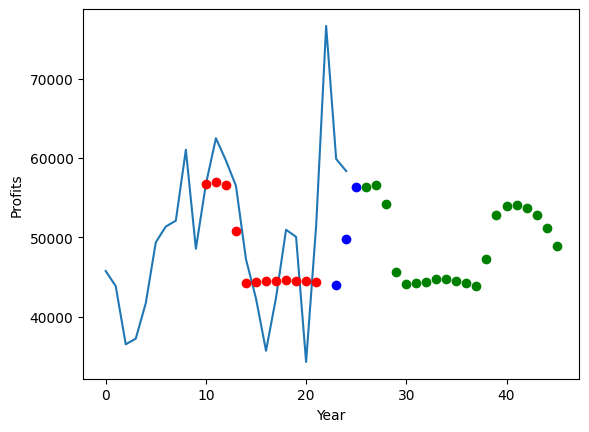

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Text(0, 0.5, 'Profits')

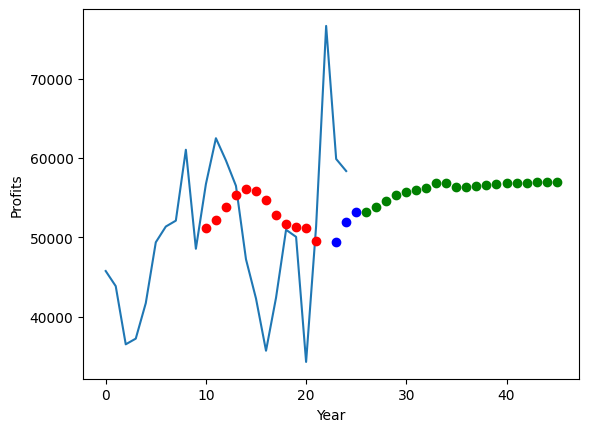

In [79]:
predictions = []
current_input = x_test[-1]

num_future = 20

for _ in range(num_future):
  next_prediction = regressor2.predict(current_input.reshape(1,-1))
  predictions.append(next_prediction)

  current_input = np.append(current_input[1:], next_prediction)

predictions = np.squeeze(np.array(predictions))


y_pred = regressor2(x_train)
y_pred_normal = sc.inverse_transform(y_pred)
plt.plot(data)
for i in range(len(y_pred_normal)):
  plt.plot(10+i, y_pred_normal[i], 'ro')

plt.plot(range(23,26), sc.inverse_transform(regressor2(x_test)), 'bo')
plt.plot(range(26,26 + num_future), sc.inverse_transform(predictions.reshape(-1,1)), 'go')
plt.xlabel('Year')
plt.ylabel('Profits')

In [68]:
regressor.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 12, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,117 (148.90 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,412 (99.27 KB)

In [65]:
current_input.shape

(10, 1)

# Other stuff

## Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, TimeDistributed, Dense

# === 1. Prepare Data ===
data = np.array([58359,59882,76678,51411,34267,50053,50946,42378,35679,42265,
                 47225,56490,59696,62503,56710,48551,61048,52098,51355,49368,
                 41689,37206,36490,43835,45742], dtype='float32')[::-1]

# Normalize (optional, but helps RNNs)
data_min, data_max = data.min(), data.max()
data = (data - data_min) / (data_max - data_min)

# Parameters
input_len = 10
forecast_len = 10

def create_data(df, n_future, n_past, train_test_split_perc, val_split_perc):

  """
  n_future: Number of days in which we want to make a prediction.
  n_past: Number of days that we want to use to make a prediction.
  """

  n_feature = df.shape[1]
  x_data, y_data = [],[]

  for i in range(n_past, len(df) - n_future + 1):
    x_data.append(df[i - n_past:i, 0:n_feature])
    y_data.append(df[i + n_future - 1: 1 + n_future, 0])

  split_train_test = int(round(train_test_split_perc*len(x_data)))
  split_train_val = int(round(split_train_test*(1-val_split_perc)))

  x_train = x_data[:split_train_test]
  y_train = y_data[:split_train_test]

  x_test = x_data[split_train_test:]
  y_test = x_data[split_train_test:]

  x_val = x_data[split_train_val:split_train_test]
  y_val = y_data[split_train_val:split_train_test]

  return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data, n_future = 1, n_past = 25, train_test_split_perc = 0.8,
                                                             val_split_perc = 0)
X, y = [], []
for i in range(len(data) - input_len - forecast_len + 1):
    X.append(data[i:i+input_len])
    y.append(data[i+input_len:i+input_len+forecast_len])

X = np.array(X)
y = np.array(y)

# Reshape: [samples, timesteps, features]
X = X.reshape((X.shape[0], input_len, 1))
y = y.reshape((y.shape[0], 1, forecast_len))  # output at each timestep will be 10 values

# Repeat output across all input timesteps to use TimeDistributed(Dense(10))
y = np.repeat(y, input_len, axis=1)

# === 2. Build Model ===
model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=(input_len, 1)),
    SimpleRNN(20, return_sequences=True),
    TimeDistributed(Dense(forecast_len))
])

model.compile(optimizer='adam', loss='mse', metrics = ["mse"])
model.summary()

# === 3. Train Model ===
history = model.fit(X, y, epochs=300, verbose=1, batch_size = 4)

# === 4. Predict Next 10 Steps ===
last_sequence = data[-input_len:]  # last known sequence
last_sequence = last_sequence.reshape((1, input_len, 1))
predicted = model.predict(last_sequence)[0, -1]  # take prediction from last timestep

# Denormalize
predicted = predicted * (data_max - data_min) + data_min
print("Predicted next 10 values:", predicted)


In [ ]:
X.shape, y.shape

Text(0, 0.5, 'Mean squared error')

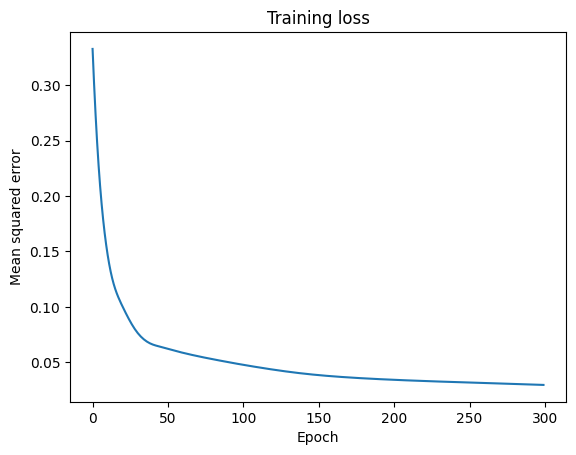

In [ ]:
plt.plot(history.history['loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')

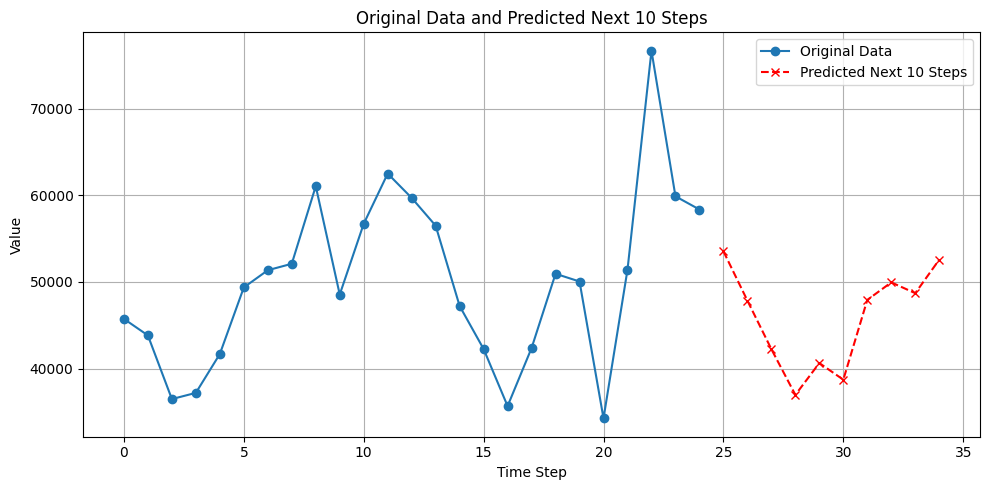

In [ ]:
import matplotlib.pyplot as plt

# Original (denormalized) data
original_data = data * (data_max - data_min) + data_min

# X-axis for the original and predicted data
time_original = np.arange(len(original_data))
time_predicted = np.arange(len(original_data), len(original_data) + len(predicted))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_original, original_data, label="Original Data", marker='o')
plt.plot(time_predicted, predicted, label="Predicted Next 10 Steps", marker='x', linestyle='--', color='red')

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Original Data and Predicted Next 10 Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 10
X, y = create_sequences(normalized_data, seq_length)

In [ ]:
# Split into train/val/test
n_total = len(X)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)

In [ ]:
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

# Reshape for LSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Model

In [ ]:
y = np.empty((1, len(data), 10))
for step_ahead in range(1, 10 + 1):
  y[:,:, step_ahead] = data[step_ahead:step_ahead + len(data)].reshape(1,-1) # Check these dimensions by print

ValueError: could not broadcast input array from shape (1,24) into shape (1,25)

In [ ]:
y[:,:,2].shape

(1, 25)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def create_model(model_name):
  if model_name == 'Ridge':
    model = Ridge()
    model.fit(X_train[:,:,0], y_train)

  elif model_name == 'LSTM':
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, verbose=0)


  return model

#model_used = 'Ridge'
model_used = 'LSTM'

model = create_model(model_used)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Evaluate
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE with model {model_used}: {loss:.5f}")

Test MSE with model LSTM: 1.74668


## Predictions

Next 10 predicted values:
[59098, 56776, 48002, 40413, 40810, 50419, 53633, 80635, 55429, 50016]


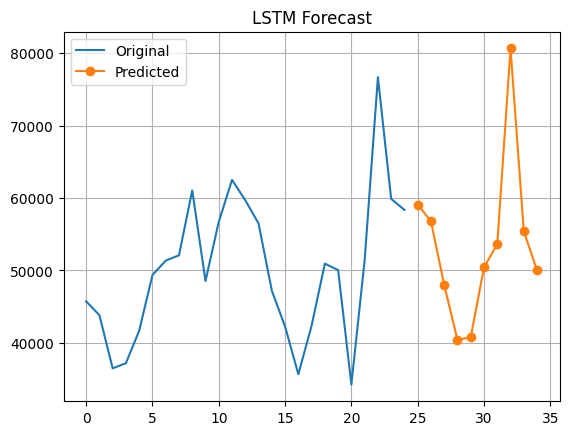

In [ ]:
# Predict next 10 values
input_seq = normalized_data[-seq_length:].reshape(1, seq_length, 1)
predictions = []
for _ in range(10):
    next_val = model.predict(input_seq, verbose=0)[0][0]
    predictions.append(next_val)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)

# Denormalize
predicted_values = (np.array(predictions) * std) + mean
print("Next 10 predicted values:")
print(predicted_values.astype(int).tolist())

# Plot
plt.plot(range(len(data)), data, label="Original")
plt.plot(range(len(data), len(data)+10), predicted_values, label="Predicted", marker='o')
plt.grid()
plt.legend()
plt.title(f"{model_used} Forecast")
plt.show()

In [ ]:
# === 1. Prepare Data ===
data = np.array([58359,59882,76678,51411,34267,50053,50946,42378,35679,42265,
                 47225,56490,59696,62503,56710,48551,61048,52098,51355,49368,
                 41689,37206,36490,43835,45742], dtype='float32')[::-1]

data1 = np.random.rand((len(data)))
data2 = np.random.rand((len(data)))
data3 = np.random.rand((len(data)))

V = np.array([data, data1, data2, data3])
df = pd.DataFrame(data = V.T, columns = ['Ingresos explotación', 'data1', 'data2', 'data3'])

In [ ]:
import pandas as pd
V = np.array([data, data1, data2, data3])
df = pd.DataFrame(data = V.T, columns = ['Ingresos explotación', 'data1', 'data2', 'data3'])
X_train, y_train = df.iloc[:20, :], df.iloc[20, 0]
X_test, y_test = df.iloc[21:, :], df.iloc[21:, 0]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model architecture
model = Sequential()
n_time_steps = len(data) - 1
n_features = 4


# LSTM layer with 50 units
model.add(LSTM(50, activation='relu', input_shape=(n_time_steps, n_features), return_sequences=True))

# Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Another LSTM layer
model.add(LSTM(50, activation='relu'))

# Output layer for predicting the next value
model.add(Dense(1))  # Predict one value

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Mean Squared Error for regression tasks

# Model summary to see the architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Assuming X_train, y_train are your features and target
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


IndexError: tuple index out of range

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Your data
data = np.array([58359,59882,76678,51411,34267,50053,50946,42378,35679,42265,
                 47225,56490,59696,62503,56710,48551,61048,52098,51355,49368,
                 41689,37206,36490,43835,45742], dtype='float32')[::-1]

# Random data
data1 = np.random.rand(len(data))
data2 = np.random.rand(len(data))
data3 = np.random.rand(len(data))

# Creating the DataFrame
V = np.array([data, data1, data2, data3])
df = pd.DataFrame(data=V.T, columns=['Ingresos explotación', 'data1', 'data2', 'data3'])

# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)  # Scale all variables (Ingresos explotación, data1, data2, data3)

# Create sequences for model input
def create_sequences(data, target_col, n_time_steps):
    X, y = [], []
    for i in range(n_time_steps, len(data)):
        # Use previous `n_time_steps` as input features
        X.append(data[i - n_time_steps:i])  # Input sequence
        y.append(data[i, target_col])  # Target value
    return np.array(X), np.array(y)

# Parameters
n_time_steps = 3  # Number of time steps to look back for prediction
target_col = 0  # 'Ingresos explotación' is in the first column (index 0)

# Create the input and target sequences
X, y = create_sequences(df_scaled, target_col, n_time_steps)

# Shape of X will be (samples, time_steps, features)
print(X.shape, y.shape)


(22, 3, 4) (22,)


In [ ]:
df

,Ingresos explotación,data1,data2,data3
0,45742.0,0.089065,0.130276,0.922667
1,43835.0,0.651802,0.555329,0.829469
2,36490.0,0.554628,0.988316,0.291145
3,37206.0,0.864534,0.604041,0.435098
4,41689.0,0.618872,0.784891,0.286114
5,49368.0,0.991237,0.020251,0.100623
6,51355.0,0.793032,0.861130,0.151297
7,52098.0,0.230852,0.829041,0.570918
8,61048.0,0.317775,0.396986,0.669362
9,48551.0,0.250387,0.249525,0.994089


In [ ]:
X.shape

(22, 3, 4)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(17, 3, 4) (17,)
(5, 3, 4) (5,)


In [ ]:
y_test

array([0.        , 0.40423475, 1.        , 0.60397067, 0.56806017])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add an LSTM layer
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Add a Dropout layer to reduce overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(50, activation='relu'))

# Output layer to predict the next value of 'Ingresos explotación'
model.add(Dense(1))  # Predict a single value for 'Ingresos explotación'

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Mean Squared Error for regression tasks

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 3, 50)          │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
# Predict the next values on the test data
y_pred = model.predict(X_test)

# Denormalize the predictions to get the real values
y_pred_denorm = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]

# Compare predictions with actual values
y_test_denorm = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], df_scaled.shape[1] - 1))), axis=1))[:, 0]

print("Predicted values: ", y_pred_denorm)
print("Actual values: ", y_test_denorm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Predicted values:  [49416.13954341 50202.0638774  51043.7585777  50157.14069819
 50389.16331953]
Actual values:  [34267. 51411. 76678. 59882. 58359.]


In [ ]:
y_pred_denorm

array([49416.13954341, 50202.0638774 , 51043.7585777 , 50157.14069819,
       50389.16331953])

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1163
Test Loss: 0.11632486432790756


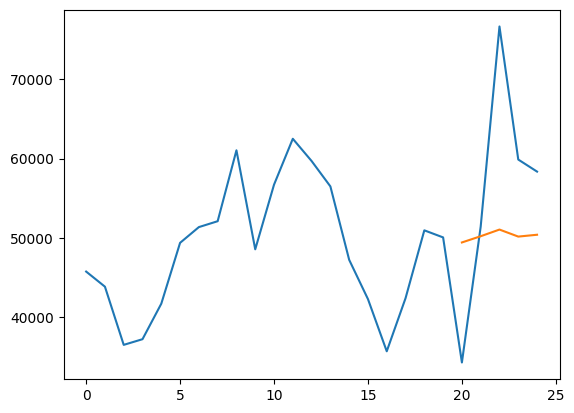

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.iloc[:,0])
plt.plot(range(20,25), y_pred_denorm)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, TimeDistributed, Dense

# === 1. Prepare Data ===
data = np.array([58359,59882,76678,51411,34267,50053,50946,42378,35679,42265,
                 47225,56490,59696,62503,56710,48551,61048,52098,51355,49368,
                 41689,37206,36490,43835,45742], dtype='float32')[::-1]

# Normalize (optional, but helps RNNs)
data_min, data_max = data.min(), data.max()
data = (data - data_min) / (data_max - data_min)

# Parameters
input_len = 10
forecast_len = 10

def create_data(df, n_future, n_past, train_test_split_perc, val_split_perc):

  """
  n_future: Number of days in which we want to make a prediction.
  n_past: Number of days that we want to use to make a prediction.
  """

  n_feature = df.shape[1]
  x_data, y_data = [],[]

  for i in range(n_past, len(df) - n_future + 1):
    x_data.append(df[i - n_past:i, 0:n_feature])
    y_data.append(df[i + n_future - 1: 1 + n_future, 0])

  split_train_test = int(round(train_test_split_perc*len(x_data)))
  split_train_val = int(round(split_train_test*(1-val_split_perc)))

  x_train = x_data[:split_train_test]
  y_train = y_data[:split_train_test]

  x_test = x_data[split_train_test:]
  y_test = x_data[split_train_test:]

  x_val = x_data[split_train_val:split_train_test]
  y_val = y_data[split_train_val:split_train_test]

  return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data, n_future = 1, n_past = 25, train_test_split_perc = 0.8,
                                                             val_split_perc = 0)


IndexError: tuple index out of range